# Depression and Anxiety classification visualization

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [1]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score

from mne.time_frequency import tfr_morlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

from mne.time_frequency import (
    tfr_multitaper,
    tfr_stockwell,
    tfr_morlet,
    tfr_array_morlet,
    AverageTFR,
)

## Load data

In [57]:
results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/FLA/depression_rewp_freq_results_t20-t30_20_04_bigger.pkl")
results_dep_frn_df = pd.read_pickle("data/sonata_data/results/FLA/depression_frn_results_freq_t20-t30_21_04_bigger.pkl")
results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/FLA/anxiety_rewp_freq_results_t20-t30_21_04_bigger.pkl")
results_anx_frn_df = pd.read_pickle("data/sonata_data/results/FLA/anxiety_frn_freq_results_t20-t30_21_04_bigger.pkl")

In [25]:
data_df = pd.DataFrame()

for dataset in [results_dep_rewp_df, results_dep_frn_df, results_anx_rewp_df, results_anx_frn_df]:
    for index, row in dataset.iterrows():

        metrics = ['mean_test_balanced_accuracy','mean_test_precision', 'mean_test_recall']

        for metric in metrics:
            band = 'delta' if row.pipeline_name.split("_")[3] == '0' else 'theta'
            model_name = row.pipeline_name.split("_")[0] + ' ' + band
            this_data = pd.DataFrame({
                'model': [model_name],
                'dataset': [row.pipeline_name.split("_")[1]],
                'score': [row[metric]],
                'metric': [metric],
            })

            data_df = pd.concat([data_df,this_data]) 

In [58]:
results_dep_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Depression_band_0_svc,0.718037,0.586389,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.1, 'svc...",0.034965,0.546667,0.550347,0.668403,0.588472,0.533889,0.586389,0.608889
0,svc,RewP_Depression_band_1_svc,0.979262,0.613611,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.1, 'svc...",0.004995,0.618333,0.569444,0.585069,0.590949,0.616111,0.613611,0.619326


In [59]:
results_dep_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Depression_band_0_svc,0.924372,0.669167,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 4, 'csp__reg': 0.01, 'sv...",0.001998,0.656667,0.630208,0.598958,0.628611,0.810556,0.669167,0.647339
0,svc,FRN_Depression_band_1_svc,0.910293,0.602222,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.001, 's...",0.005994,0.503333,0.538194,0.645833,0.562454,0.607222,0.602222,0.584241


In [60]:
results_anx_rewp_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,RewP_Anxiety_band_0_svc,0.688942,0.548341,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 1, 'svc__...",0.150849,0.601732,0.489177,0.523810,0.538240,0.489899,0.548341,0.563492
0,svc,RewP_Anxiety_band_1_svc,0.914423,0.619769,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 3, 'csp__reg': 0.1, 'svc...",0.005994,0.623377,0.508658,0.636364,0.589466,0.599567,0.619769,0.629718


In [61]:
results_anx_frn_df

,model_name,pipeline_name,train score,mean_cv_score,best_model,parameters,pvalue,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,mean_test_recall,mean_test_balanced_accuracy,mean_test_precision
0,svc,FRN_Anxiety_band_0_svc,0.644591,0.580447,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 1, 'csp__reg': 1, 'svc__...",0.079920,0.696970,0.461039,0.664502,0.607504,0.491342,0.580447,0.635531
0,svc,FRN_Anxiety_band_1_svc,0.845313,0.522727,"(CSP({'component_order': 'mutual_info',\n 'cov...","{'csp__n_components': 2, 'csp__reg': 0.1, 'svc...",0.330669,0.577922,0.400433,0.623377,0.533911,0.404040,0.522727,0.501888


For violin

In [ ]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_freq_results_29_03.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_results_freq_29_03.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_freq_results_29_03.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_freq_results_29_03.pkl")

In [250]:
rewp_depression_datasets = np.load('data/rewp_depression_dataset.npy')
frn_depression_datasets = np.load('data/frn_depression_datasets.npy')
rewp_anxiety_datasets = np.load('data/rewp_anxiety_datasets.npy')
frn_anxiety_datasets = np.load('data/frn_anxiety_datasets.npy')

In [260]:
%%capture
long_data_df = pd.DataFrame()

size = int(len(rewp_depression_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy','precision', 'recall']
y = np.array(size * [1] +  size * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_dep_rewp_df, rewp_depression_datasets), (results_dep_frn_df,frn_depression_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'
                
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

In [261]:
long_data_df

,model,dataset,band,scores,metric
0,RewP,Depression,delta,0.475,balanced_accuracy
1,RewP,Depression,delta,0.450,balanced_accuracy
2,RewP,Depression,delta,0.675,balanced_accuracy
3,RewP,Depression,delta,0.650,balanced_accuracy
4,RewP,Depression,delta,0.525,balanced_accuracy
...,...,...,...,...,...
95,FRN,Depression,theta,1.000,recall
96,FRN,Depression,theta,1.000,recall
97,FRN,Depression,theta,1.000,recall
98,FRN,Depression,theta,1.000,recall


In [26]:
%%capture
# data_df = pd.DataFrame()

size = int(len(rewp_anxiety_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy','precision', 'recall']
y = np.array(size * [1] +  size * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_anx_rewp_df, rewp_anxiety_datasets), (results_anx_frn_df,frn_anxiety_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'
                
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

NameError: name 'rewp_anxiety_datasets' is not defined

In [264]:
long_data_df

,model,dataset,band,scores,metric
0,RewP,Depression,delta,0.475000,balanced_accuracy
1,RewP,Depression,delta,0.450000,balanced_accuracy
2,RewP,Depression,delta,0.675000,balanced_accuracy
3,RewP,Depression,delta,0.650000,balanced_accuracy
4,RewP,Depression,delta,0.525000,balanced_accuracy
...,...,...,...,...,...
95,FRN,Anxiety,theta,0.666667,recall
96,FRN,Anxiety,theta,0.666667,recall
97,FRN,Anxiety,theta,0.666667,recall
98,FRN,Anxiety,theta,0.666667,recall


In [37]:
names_dict = {
    'mean_test_balanced_accuracy': 'ACC',
    'mean_test_precision': 'precision',
    'mean_test_roc_auc': 'ROC',
    'mean_test_recall': 'recall',
    'RewP delta': 'FP delta',
    'RewP theta': 'FP theta',
    'FRN delta': 'FN delta',
    'FRN theta': 'FN theta',
}

In [265]:
long_names_dict = {
    'balanced_accuracy': 'ACC',
}

In [38]:
data_df['metric'] = data_df['metric'].replace(names_dict)
data_df['model'] = data_df['model'].replace(names_dict)
# long_data_df['metric'] = long_data_df['metric'].replace(long_names_dict)

In [39]:
data_df

,model,dataset,score,metric
0,FP delta,Depression,0.618651,ACC
0,FP delta,Depression,0.621154,precision
0,FP delta,Depression,0.607143,recall
0,FP theta,Depression,0.530159,ACC
0,FP theta,Depression,0.522343,precision
0,FP theta,Depression,0.559524,recall
0,FN delta,Depression,0.578571,ACC
0,FN delta,Depression,0.573016,precision
0,FN delta,Depression,0.639683,recall
0,FN theta,Depression,0.580159,ACC


### Visualize results

In [40]:
import matplotlib.lines as lines

In [43]:
data = data_df[data_df['metric'] == 'ACC']
data

,model,dataset,score,metric
0,FP delta,Depression,0.618651,ACC
0,FP theta,Depression,0.530159,ACC
0,FN delta,Depression,0.578571,ACC
0,FN theta,Depression,0.580159,ACC
0,FP delta,Anxiety,0.606140,ACC
0,FP theta,Anxiety,0.596992,ACC
0,FN delta,Anxiety,0.583166,ACC
0,FN theta,Anxiety,0.620301,ACC


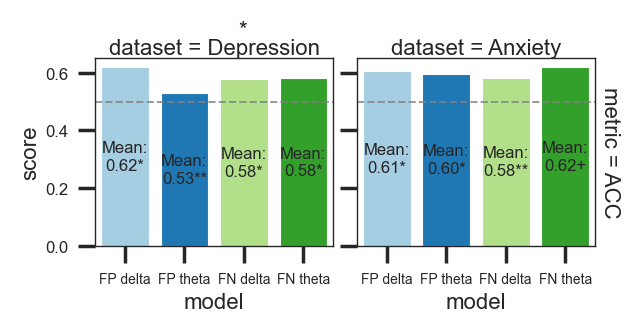

In [52]:
cm = 1/2.54
dpi = 200

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rc('font', size=6)

sns.set_palette('Paired')


sns.set_style("ticks")

g = sns.FacetGrid(
    data, 
    col="dataset", 
    row='metric', 
    margin_titles=True,
    # palette = 'dark',
    despine=False,
    sharex = True,
    hue='model',
    aspect=1.3
)

g.map(
    sns.barplot,
    'model',
    'score',
    order=['FP delta', 'FP theta', 'FN delta', 'FN theta'],
    saturation=1,
    linewidth=0.4
)
g.figure.subplots_adjust(wspace=.1, hspace=.05)

axes = g.axes.flatten()

 # add vlines
axes[0].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[1].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[2].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[3].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[4].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[5].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)

# add the annotation

axes[0].bar_label(axes[0].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[1], fmt='Mean:\n%.2f**', label_type='center')
axes[0].bar_label(axes[0].containers[2], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[3], fmt='Mean:\n%.2f*', label_type='center')


axes[1].bar_label(axes[1].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[1], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[2], fmt='Mean:\n%.2f**', label_type='center')
axes[1].bar_label(axes[1].containers[3], fmt='Mean:\n%.2f+', label_type='center')


# for ax in axes[2:]:
#     ax.bar_label(ax.containers[0], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[1], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[2], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[3], fmt='Mean:\n%.2f', label_type='center')


# for ax in axes:
#     ax.add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 2], [0.8, 0.8], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 3], [0.85, 0.85], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

#     ax.add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

        
#     ax.add_artist(lines.Line2D([2, 2], [0.787, 0.81], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 0], [0.787, 0.81], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([0, 0], [0.835, 0.86], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([3, 3], [0.835, 0.86], color='black', linewidth=0.7))
    
# add significance markers
# ACC
# axes[0].add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

# axes[0].add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
# axes[0].add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

axes[0].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

# axes[0].text(1.45, 0.7, '+', fontsize=6)
axes[0].text(1.9, 0.73, '*', fontsize=8)

# precision
# axes[2].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

# axes[2].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
# axes[2].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

# axes[2].text(1.9, 0.73, '**', fontsize=8)

#recall


fig = g.fig
fig.set_size_inches(7*cm, 3*cm)

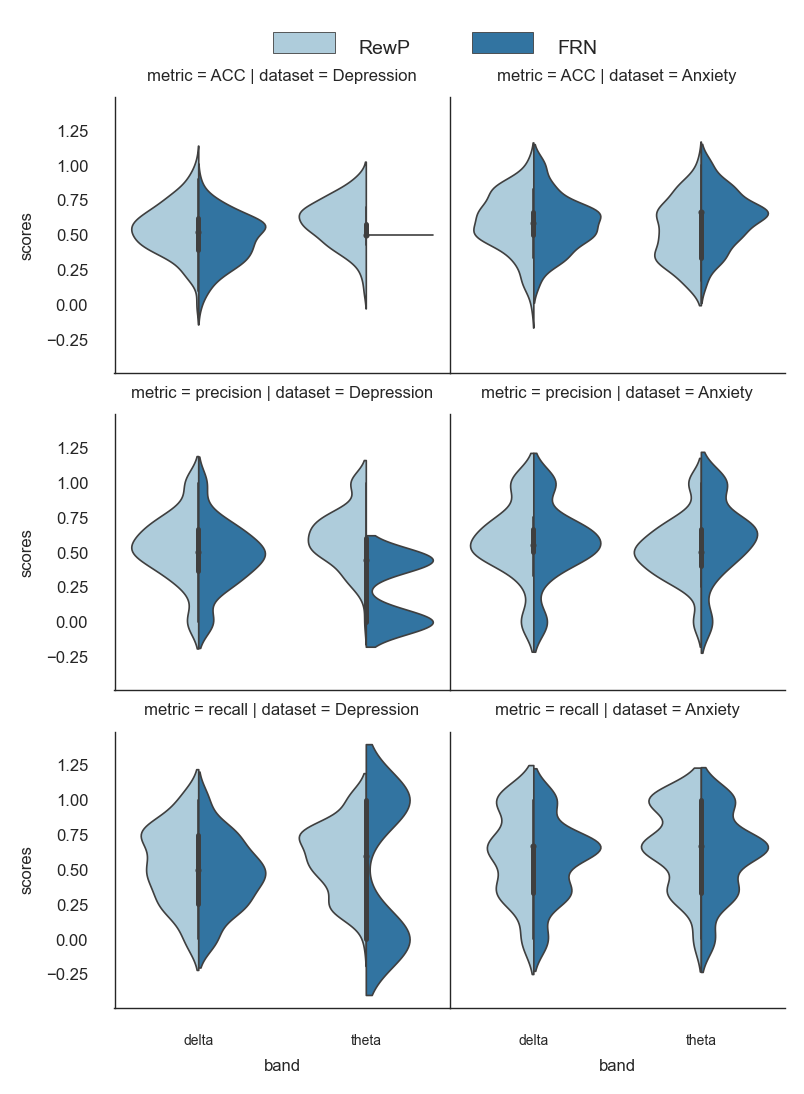

In [326]:
cm = 1/2.54
dpi = 200

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rc('font', size=6)

sns.set_palette('Paired')
sns.set_style("white")

g = sns.catplot(
    x='band', 
    y='scores', 
    hue='model',
    row='metric', 
    col='dataset', 
    data=long_data_df, 
    kind='violin', 
    height=6,
    split = True,
    despine = False,
    legend_out = False,
    linewidth = 0.6
)

g.figure.subplots_adjust(wspace=.0, hspace=.15)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

plt.setp(g._legend.get_texts(), fontsize=7)

fig = g.fig
fig.set_size_inches(9*cm, 12*cm)

### Plot features

Plot CSP components for:
- RewP depression
- FRN depression
- RewP anxiety
- FRN anxiety

In [327]:
datasets = [rewp_depression_datasets, frn_depression_datasets, rewp_anxiety_datasets, frn_anxiety_datasets]

In [ ]:
# plot CSP patterns estimated on full data for visualization
epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_channels(['P1', 'P2', 'P4', 'P3', 'CP3', 'CP4', 'CP1', 'CP2', 'Pz', 'CPz',])

epochs_train.info

csp.fit_transform(evoked_data, y)

fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Plot theta & delta 

In [2]:
data = pd.read_csv('data/q_data.csv')

In [3]:
data['disorder'] = 0
for i in range(len(data)):
    if data['BDI'][i] != '#NULL!' and data['BDI'][i] >= 13:
        data['disorder'][i] = 1
    else:
        data['disorder'][i] = 0

/tmp/ipykernel_4807/1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
/tmp/ipykernel_4807/1494664159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 1


In [4]:
data

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder
0,507,99.0,NaN,1,19,0.0,0.00,0.00,0.00,23.0,...,753.41,722.02,828.73,728.22,721.10,905.28,785.73,0.12,0.00,0
1,508,99.0,NaN,1,18,4.0,0.00,0.67,0.17,47.0,...,932.63,772.36,986.75,771.20,896.43,1202.03,968.84,0.28,0.93,0
2,509,99.0,NaN,1,18,7.0,0.17,0.00,0.67,44.0,...,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0
3,510,99.0,NaN,1,19,1.0,0.00,0.00,0.17,27.0,...,1239.09,1231.04,1500.54,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0
4,511,99.0,NaN,2,22,1.0,0.00,0.00,0.17,23.0,...,1527.80,1908.43,1305.88,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,624,1.0,NaN,1,20,23.0,1.33,1.00,0.67,60.0,...,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81,1
117,625,2.0,subsyndromal current,1,19,16.0,0.67,1.00,0.83,60.0,...,1149.39,1130.02,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00,1
118,626,1.0,NaN,1,18,14.0,0.33,1.00,0.83,41.0,...,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38,1
119,627,2.0,NaN,2,19,30.0,1.00,1.33,2.17,47.0,...,2131.00,2065.05,2270.20,2167.89,1941.75,2261.39,2320.25,0.10,0.61,1


In [5]:
ids = data['id'][:].astype(int)

## Load EEG data

In [2]:
data_df = pd.read_pickle("data/sonata_data/freq2.pkl")

In [3]:
ids = np.load('data/sonata_data/ids/gng_fla_common_ids.npy')
ids.sort()
len(ids)

190

In [4]:
data_df = data_df[data_df['id'].isin(ids)]

In [3]:
dep = data_df[(data_df['BDI'] > 13) & (data_df['STAI'] > 41)]
len(dep)

75

In [4]:
ctrl_dep = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 41)]
len(ctrl_dep)

72

In [26]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 41)]
len(anx)

72

In [27]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

66

## Visualize positive feedback, negative feedback and difference waves topo

In [3]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta
0,000,"<Epochs | 212 events (all good), -1 - 2.39844...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 212 events (all good), -1 - 2.39844..."
1,012,"<Epochs | 181 events (all good), -1 - 2.39844...",012,45,2.33,2.00,4.33,1.67,50,"<Epochs | 181 events (all good), -1 - 2.39844..."
2,014,"<Epochs | 219 events (all good), -1 - 2.39844...",014,17,1.00,0.33,1.33,0.83,58,"<Epochs | 219 events (all good), -1 - 2.39844..."
3,037,"<Epochs | 223 events (all good), -1 - 2.39844...",037,10,0.17,1.67,1.83,0.33,51,"<Epochs | 223 events (all good), -1 - 2.39844..."
4,041,"<Epochs | 207 events (all good), -1 - 2.39844...",041,8,0.33,0.33,0.67,0.17,48,"<Epochs | 207 events (all good), -1 - 2.39844..."


In [350]:
# epochs = mne.concatenate_epochs(data_df['epochs'].to_list())
evokeds = epochs.average()

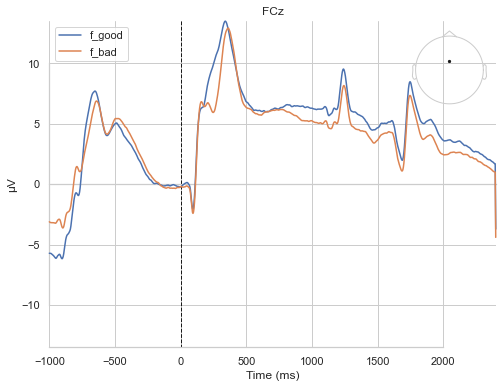

[<Figure size 576x432 with 2 Axes>]

In [10]:
mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=['FCz'], 
    ci=0.95, 
    time_unit='ms',
)

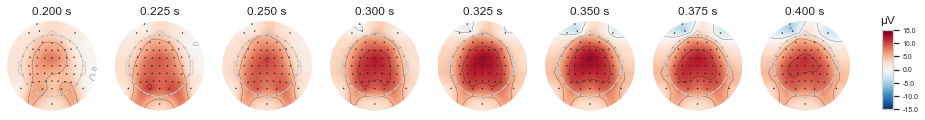

In [11]:
# f_good
fig = mne.viz.plot_evoked_topomap(
    evoked = evokeds[0],
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (15,-15)
)

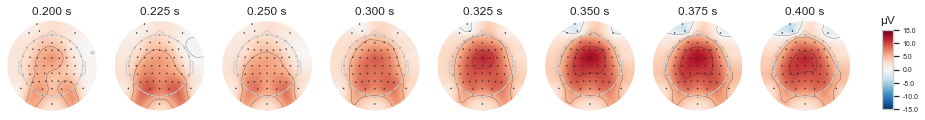

In [12]:
# f_bad
fig = mne.viz.plot_evoked_topomap(
    evoked = evokeds[1],
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (15,-15)
)

In [13]:
# diff
evokeds_diff_data = evokeds[0].get_data() - evokeds[1].get_data()
evoked_diff = mne.EvokedArray(evokeds_diff_data, info = evokeds[0].info, tmin = evokeds[0].tmin,)

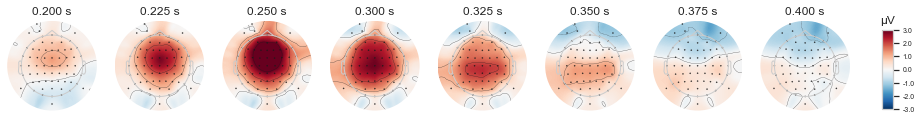

In [14]:
fig = mne.viz.plot_evoked_topomap(
    evoked = evoked_diff,
    times = [0.2, 0.225, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
    vlim = (3,-3)
)

Need more than one channel to make topography for eeg. Disabling interactivity.


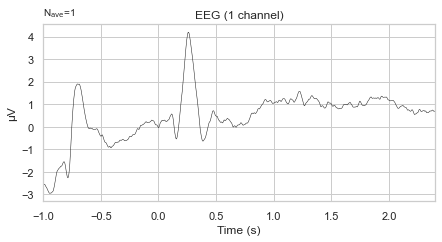

In [15]:
fig = evoked_diff.plot(picks=["FCz"])

## Visualize TFR

In [377]:
# Factor to down-sample the temporal dimension of the TFR computed by tfr_morlet.
decim = 1

# frequencies of interest in log distribution
freqs = np.linspace(0.2, 15, num=60)  
cycles = freqs / 0.8

# morelet parameters (number of cycles)
n_cycles = cycles

epochs_power = list()
tfr = list()

# perform morlet TF decomposition
tfr = tfr_morlet(evokeds, freqs, n_cycles=n_cycles,
                      decim=decim, average=True, return_itc=False, verbose=0, n_jobs=10)

# width=0.35
# fmin, fmax = freqs[[0, -1]]
# tfr = tfr_stockwell(evokeds, fmin=fmin, fmax=fmax, width=width)
# apply baseline
# tfr.apply_baseline(mode='mean', baseline=(-0.4, -0.1), verbose=0)

# tfr = tfr_multitaper(
#         evokeds[1],
#         freqs=freqs,
#         n_cycles=n_cycles,
#         time_bandwidth=2.3,
#         return_itc=False,
# )
    
# Crop in time to keep only what is between 0 and 500 ms
# tfr.crop(0, 0.5)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  68 out of  68 | elapsed:    0.2s finished


[<Figure size 720x504 with 2 Axes>]

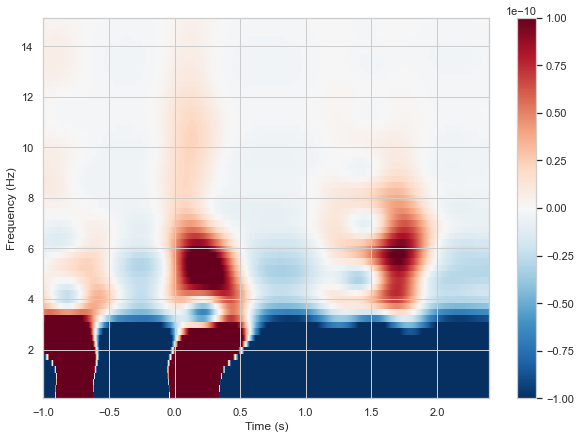

In [378]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-10,
    vmax=1e-10
)

# morlet cycles freq / 0.5

[<Figure size 720x504 with 2 Axes>]

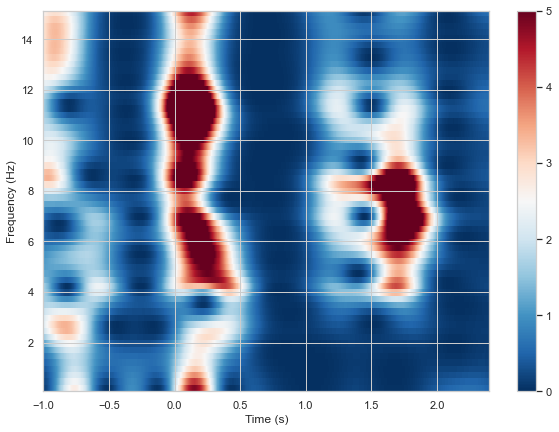

In [379]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="ratio", 
    show=False, 
    colorbar=True,
    vmin=-0,
    vmax=5
)
# morlet 0.8

Applying baseline correction (mode: mean)


[<Figure size 720x504 with 2 Axes>]

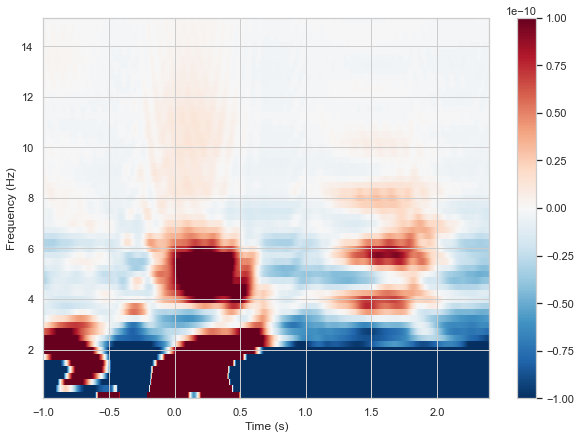

In [316]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-10,
    vmax=1e-10,
    # vmin=-1,
    # vmax=5,
)
# multitaper

[<Figure size 720x504 with 2 Axes>]

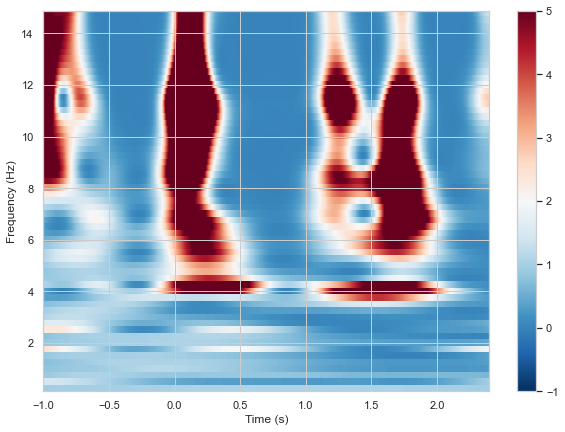

In [375]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, -0.1), 
    mode="ratio", 
    show=False, 
    colorbar=True,
    # vmin=-1e-13,
    # vmax=1e-13,
    vmin=-1,
    vmax=5,
)
# stockwell 0.35

[<Figure size 720x504 with 2 Axes>]

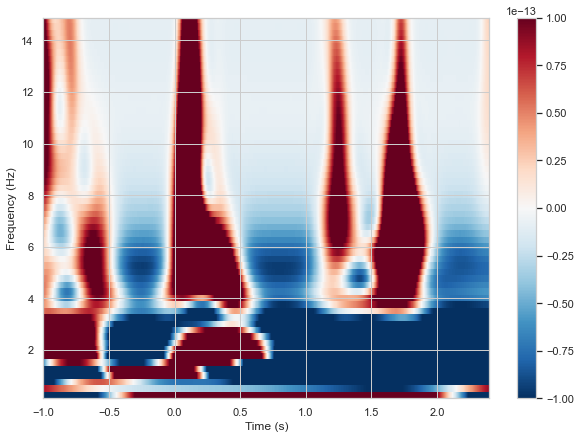

In [371]:
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    colorbar=True,
    vmin=-1e-13,
    vmax=1e-13,
)
# stockwell window 0.2

Applying baseline correction (mode: zlogratio)


[<Figure size 720x504 with 2 Axes>]

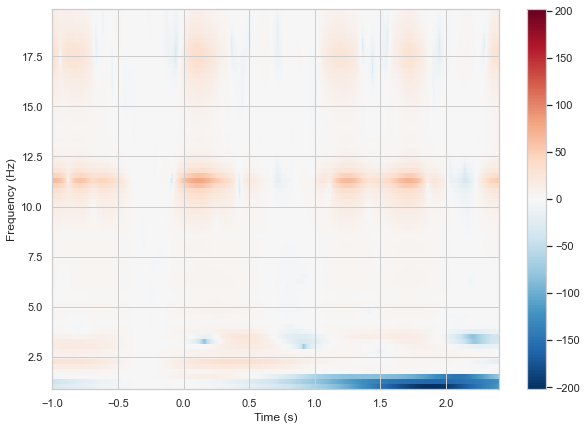

In [186]:
tfr.plot(
    ['FCz'],
    baseline=(-0.4, -0.2), 
    mode="zlogratio", 
    show=False, 
    colorbar=True,
    # vmin=-1e1,
    # vmax=1e1
)

## Visualize depressed vs control brain activity

In [4]:
freq_ranges = [(0.2,3), (4.0,7.5)]

### Delta

In [385]:
%%capture

data_df['delta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    None, 
    freq_ranges[0][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [386]:
data_df.to_pickle("data/sonata_data/freq.pkl")

In [7]:
depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())

/tmp/ipykernel_21929/2216668141.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_21929/2216668141.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [13]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

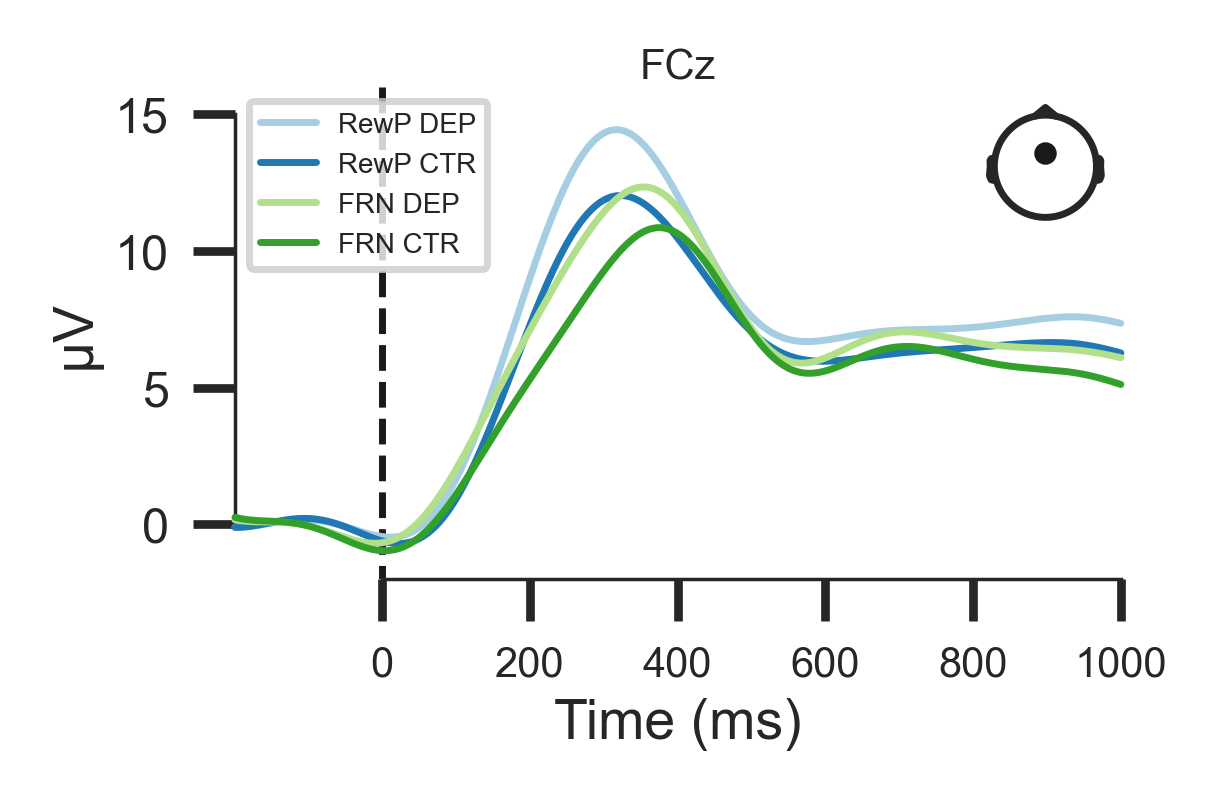

In [21]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_dep', bbox_inches='tight', pad_inches=0.01)

In [22]:
depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

/tmp/ipykernel_21929/1072237204.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_21929/1072237204.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [23]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

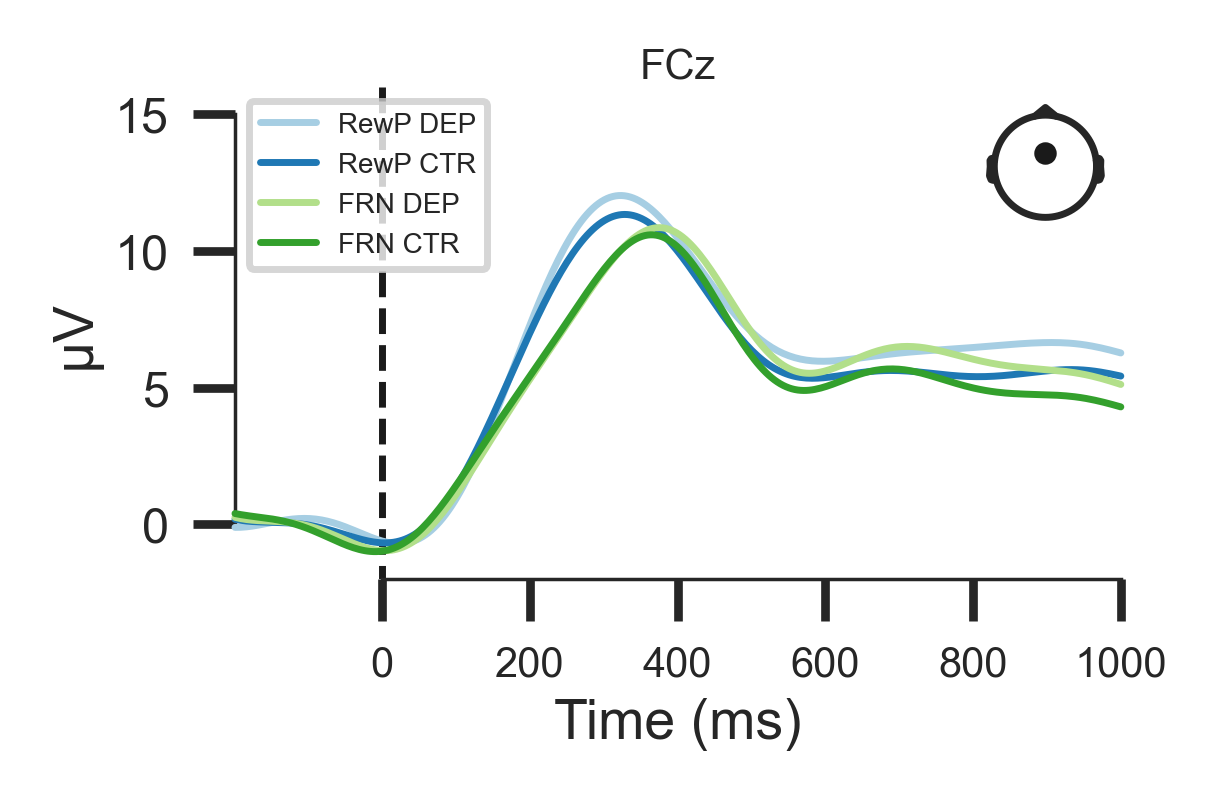

In [25]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_anx', bbox_inches='tight', pad_inches=0.01)

### Theta

In [5]:
%%capture

data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    freq_ranges[1][0], 
    freq_ranges[1][1], 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [7]:
data_df.head()

,id,epochs,Demo_kod,BDI,BDI_cognitive,BDI_affective,BDI_affect_cog,BDI_somatic,STAI,delta,theta
0,000,"<Epochs | 212 events (all good), -1 - 2.39844...",000,6,0.17,0.67,0.83,0.50,40,"<Epochs | 212 events (all good), -1 - 2.39844...","<Epochs | 212 events (all good), -1 - 2.39844..."
1,012,"<Epochs | 181 events (all good), -1 - 2.39844...",012,45,2.33,2.00,4.33,1.67,50,"<Epochs | 181 events (all good), -1 - 2.39844...","<Epochs | 181 events (all good), -1 - 2.39844..."
2,014,"<Epochs | 219 events (all good), -1 - 2.39844...",014,17,1.00,0.33,1.33,0.83,58,"<Epochs | 219 events (all good), -1 - 2.39844...","<Epochs | 219 events (all good), -1 - 2.39844..."
3,037,"<Epochs | 223 events (all good), -1 - 2.39844...",037,10,0.17,1.67,1.83,0.33,51,"<Epochs | 223 events (all good), -1 - 2.39844...","<Epochs | 223 events (all good), -1 - 2.39844..."
4,041,"<Epochs | 207 events (all good), -1 - 2.39844...",041,8,0.33,0.33,0.67,0.17,48,"<Epochs | 207 events (all good), -1 - 2.39844...","<Epochs | 207 events (all good), -1 - 2.39844..."


In [8]:
data_df.to_pickle("data/sonata_data/freq2.pkl")

In [16]:
depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())

/tmp/ipykernel_14101/3861393698.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_14101/3861393698.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [17]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

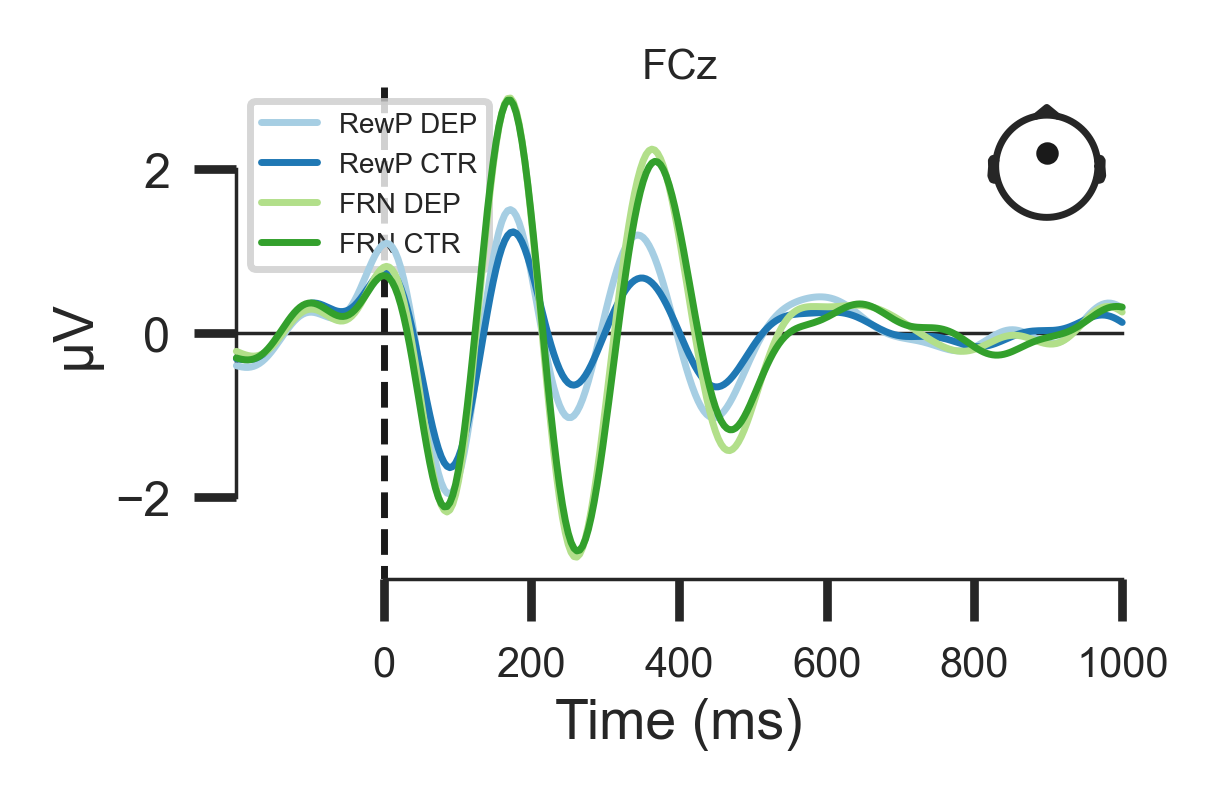

In [18]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [28]:
depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

/tmp/ipykernel_14101/1184506707.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_14101/1184506707.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [29]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

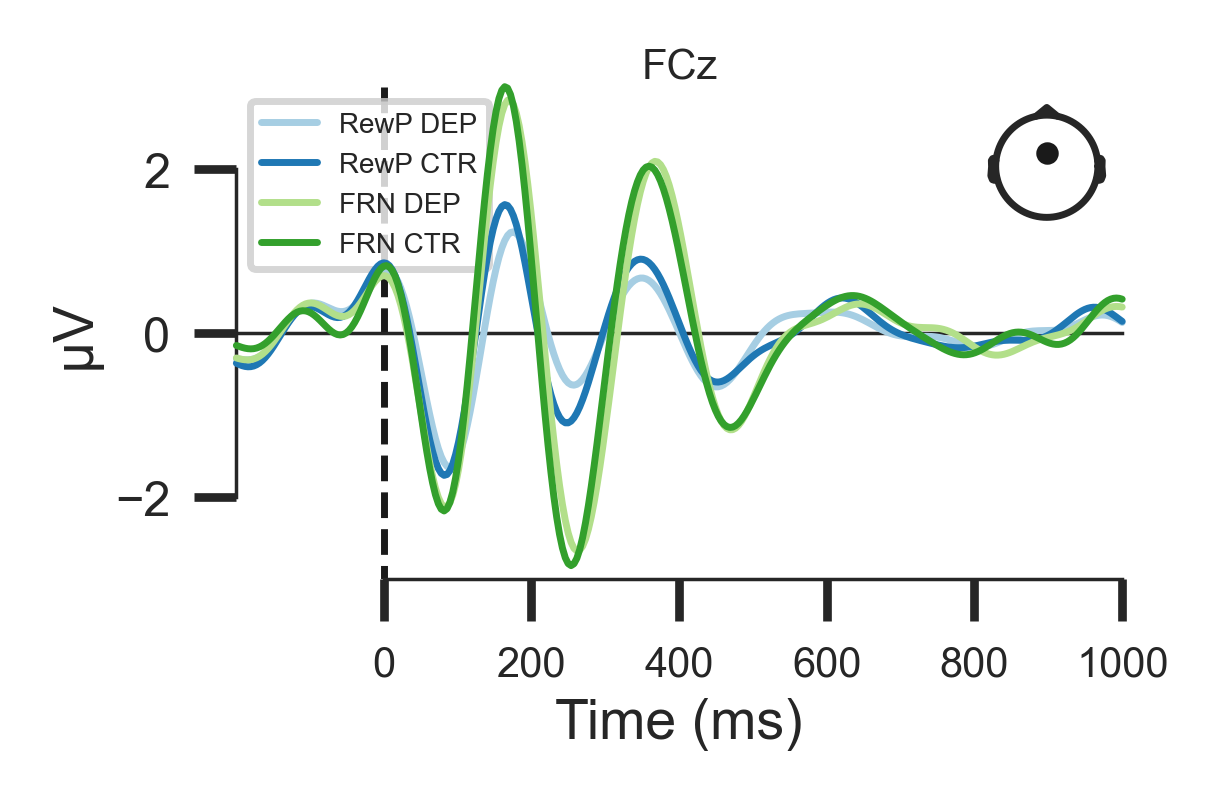

In [30]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)

## ERPs

- DEP

In [19]:
depression_epochs = mne.concatenate_epochs(dep['epochs'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['epochs'].to_list())

/tmp/ipykernel_14101/4046670063.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['epochs'].to_list())


Not setting metadata
15368 matching events found
No baseline correction applied


/tmp/ipykernel_14101/4046670063.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['epochs'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


In [20]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

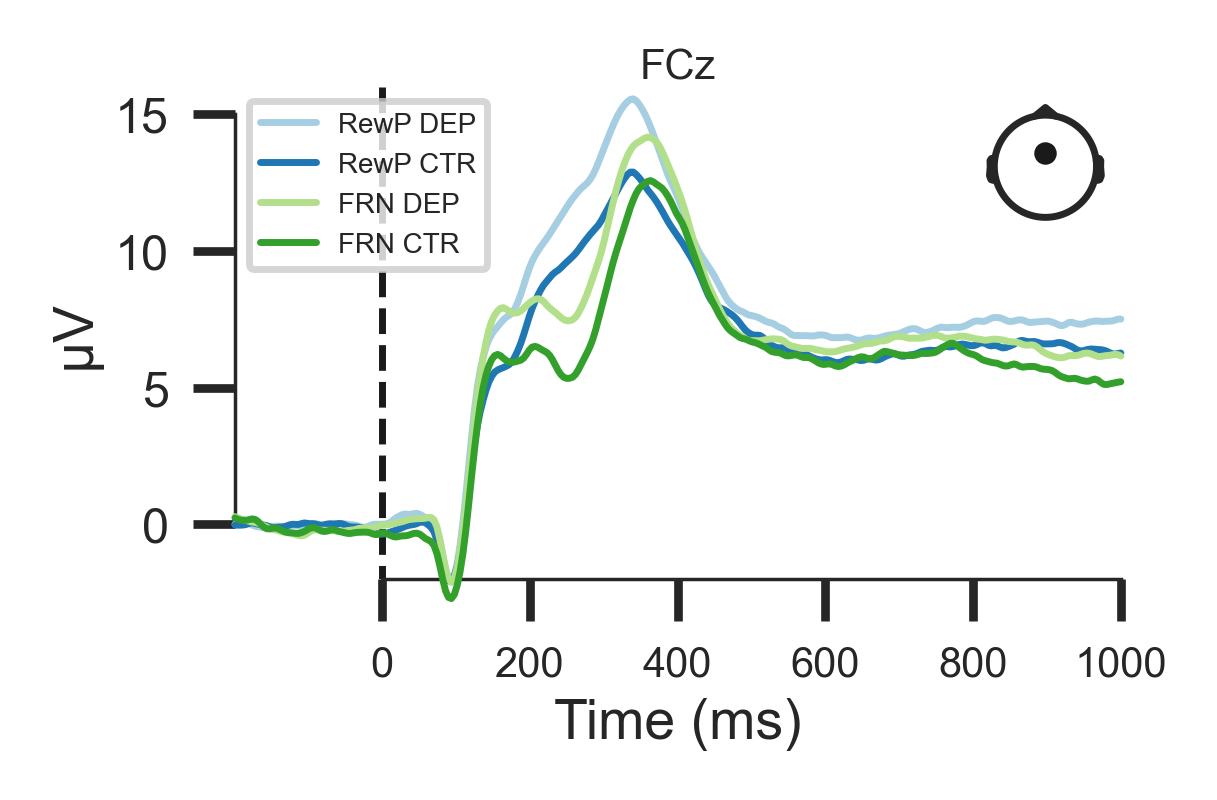

In [21]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_dep', bbox_inches='tight', pad_inches=0.01)

- ANX

In [31]:
depression_epochs = mne.concatenate_epochs(anx['epochs'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['epochs'].to_list())

/tmp/ipykernel_14101/1862082363.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['epochs'].to_list())


Not setting metadata
14688 matching events found
No baseline correction applied


/tmp/ipykernel_14101/1862082363.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['epochs'].to_list())


Not setting metadata
13523 matching events found
No baseline correction applied


In [32]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.2, tmax=1.0) for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

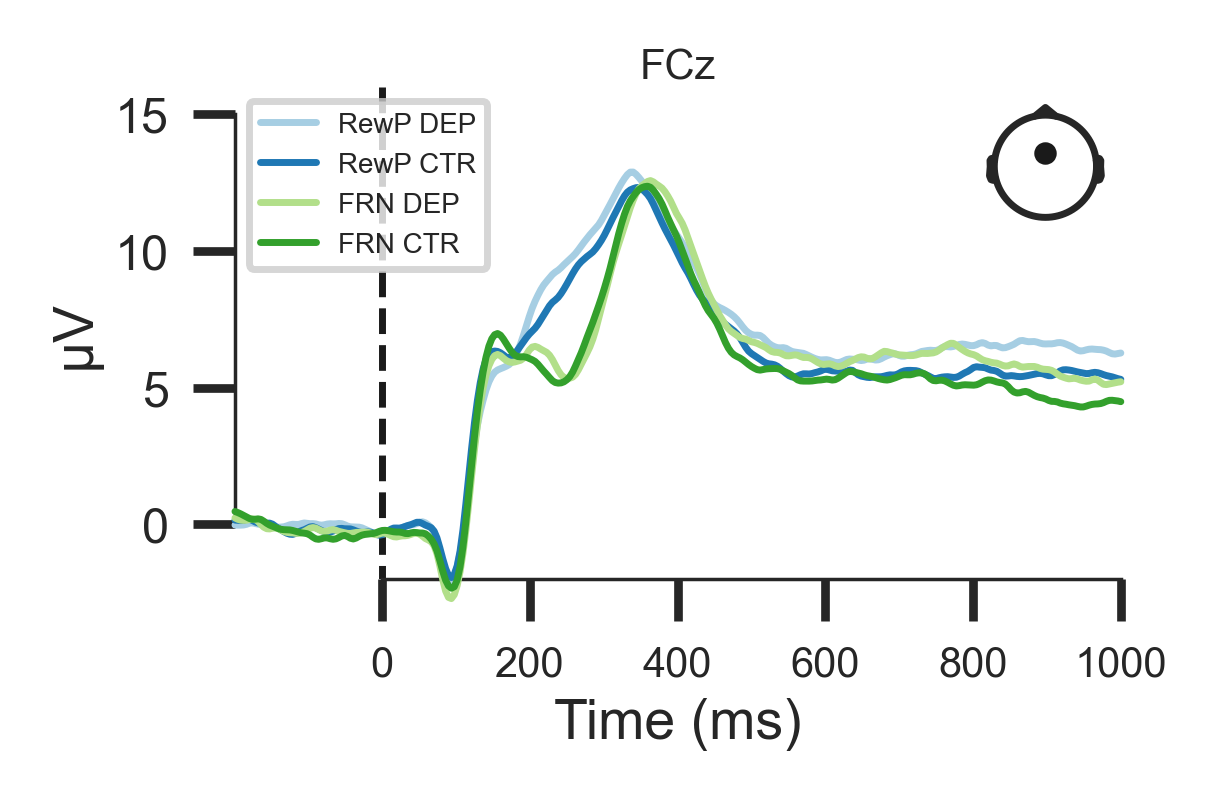

In [33]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)

In [20]:
%%capture
data_df['theta35'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    3.5, 
    8.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [21]:
dep = data_df[(data_df['BDI'] > 14) & (data_df['STAI'] > 41)]
len(dep)

67

In [22]:
ctrl_dep = data_df[(data_df['BDI'] <= 12) & (data_df['STAI'] > 41)]
len(ctrl_dep)

68

In [23]:
depression_epochs = mne.concatenate_epochs(dep['theta35'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta35'].to_list())

/tmp/ipykernel_3822/2409067025.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta35'].to_list())


Not setting metadata
16623 matching events found
No baseline correction applied


/tmp/ipykernel_3822/2409067025.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta35'].to_list())


Not setting metadata
16658 matching events found
No baseline correction applied


In [24]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

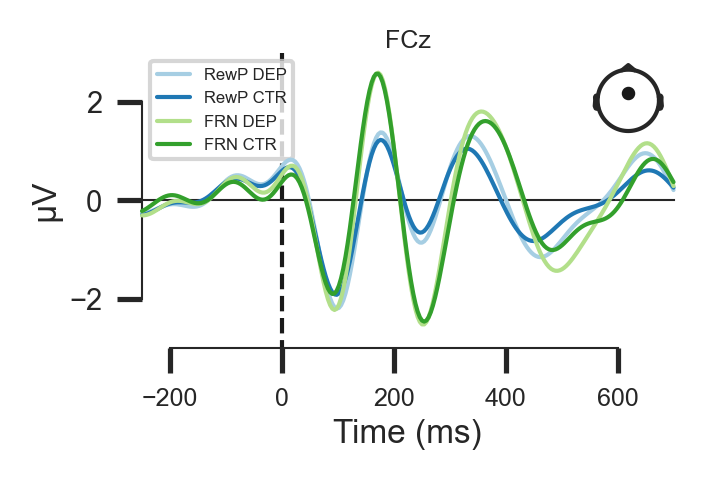

In [25]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [26]:
%%capture
data_df['theta3-9'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    3.0, 
    9.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [27]:
dep = data_df[(data_df['BDI'] > 14) & (data_df['STAI'] > 41)]
len(dep)

67

In [28]:
ctrl_dep = data_df[(data_df['BDI'] <= 12) & (data_df['STAI'] > 41)]
len(ctrl_dep)

68

In [29]:
depression_epochs = mne.concatenate_epochs(dep['theta3-9'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta3-9'].to_list())

/tmp/ipykernel_3822/3125140204.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(dep['theta3-9'].to_list())


Not setting metadata
16623 matching events found
No baseline correction applied


/tmp/ipykernel_3822/3125140204.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta3-9'].to_list())


Not setting metadata
16658 matching events found
No baseline correction applied


In [30]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

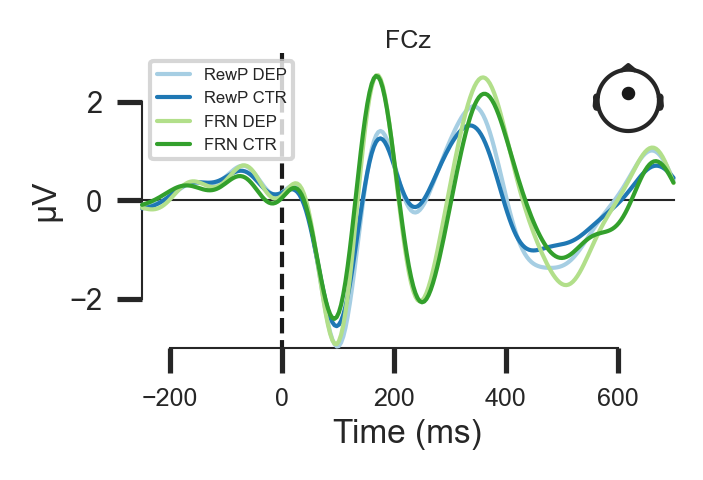

In [31]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

In [48]:
%%capture
data_df['theta'] = data_df['epochs'].apply(lambda x: x.copy().filter(
    4.0, 
    10.0, 
    fir_design='firwin', 
    skip_by_annotation='edge',
    h_trans_bandwidth = 'auto',
))

In [54]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 42)]
len(anx)

66

In [55]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

65

In [59]:
depression_epochs = mne.concatenate_epochs(anx['theta35'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta35'].to_list())

/tmp/ipykernel_3822/2088837195.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_epochs = mne.concatenate_epochs(anx['theta35'].to_list())


Not setting metadata
16160 matching events found
No baseline correction applied


/tmp/ipykernel_3822/2088837195.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta35'].to_list())


Not setting metadata
16182 matching events found
No baseline correction applied


In [60]:
evokeds_dep = [depression_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

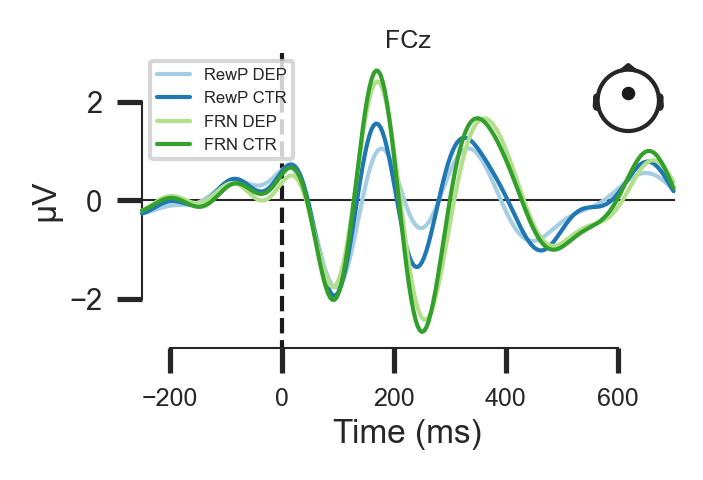

In [61]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

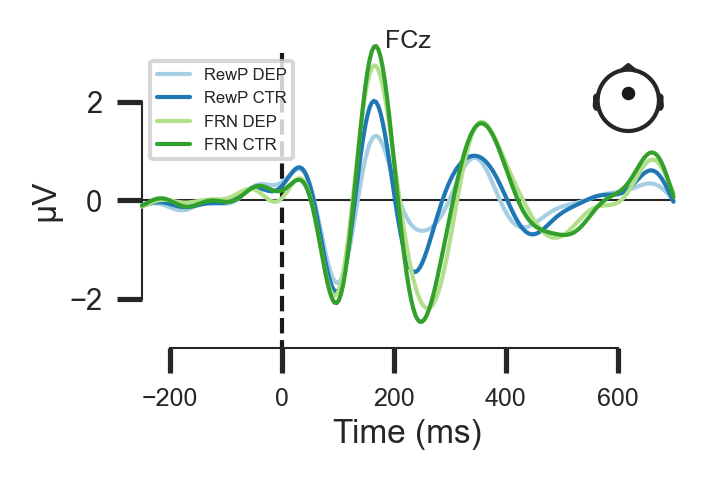

In [58]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

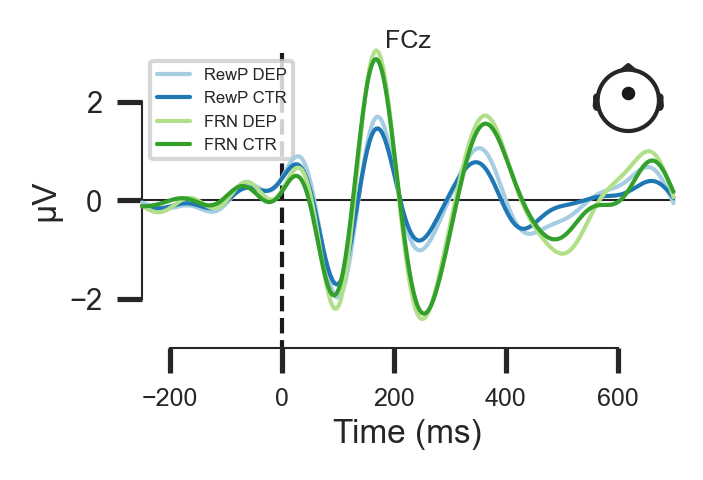

In [21]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_dep[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

## Visualize anxiety vs control brain activity

### Delta

In [9]:
anxiety_epochs = mne.concatenate_epochs(anx['delta'].to_list())
anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

/tmp/ipykernel_3772/3204259360.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_epochs = mne.concatenate_epochs(anx['delta'].to_list())


Not setting metadata
15837 matching events found
No baseline correction applied


/tmp/ipykernel_3772/3204259360.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())


Not setting metadata
16161 matching events found
No baseline correction applied


In [10]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

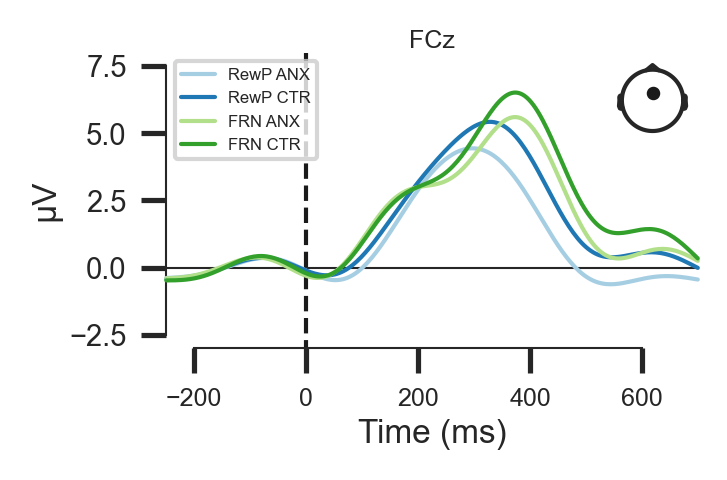

In [13]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 8]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/delta_anx', bbox_inches='tight', pad_inches=0.01)

### Theta

In [14]:
anxiety_epochs = mne.concatenate_epochs(anx['theta'].to_list())
anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

/tmp/ipykernel_3772/274733208.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_epochs = mne.concatenate_epochs(anx['theta'].to_list())


Not setting metadata
15837 matching events found
No baseline correction applied


/tmp/ipykernel_3772/274733208.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())


Not setting metadata
16161 matching events found
No baseline correction applied


In [15]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('f_good', 'f_bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('f_good', 'f_bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

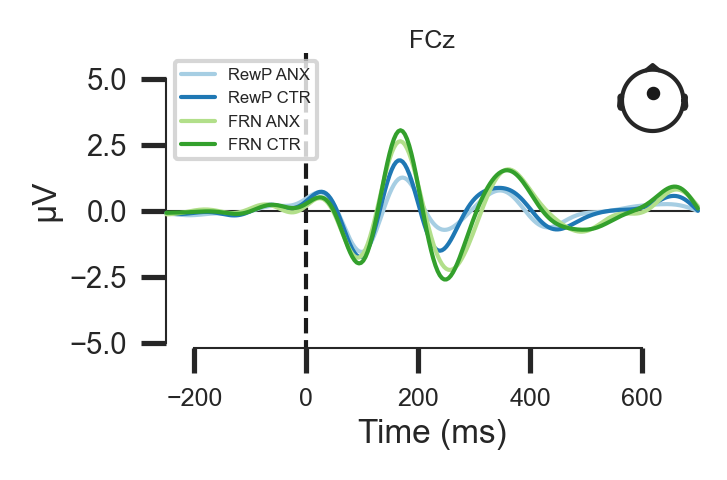

In [16]:
cm = 1/2.54
dpi = 300

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
# topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
# topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


# rewp_fig, rewP_cont = mne.viz.plot_topomap(
#     rewp_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_rewP_axis
# )
# plt.setp(rewP_cont.collections , linewidth=0.5)
# plt.setp(topo_rewP_axis.lines , linewidth=0.5)


# frn_fig, frn_cont = mne.viz.plot_topomap(
#     frn_delta_contrast.reshape(-1), 
#     evokeds_anx[0].info, 
#     show=False, 
#     res=1000, 
#     sensors=False,
#     axes=topo_FRN_axis
# )
# plt.setp(frn_cont.collections , linewidth=0.5)
# plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5.2, 6]),
    axes=ax,
    time_unit='ms',
)


# fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)